In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
! pip install catboost
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay 
import pickle
from pickle import load

# Описание проекта 

Для маркетплейса необходимо разработать модель, которая будет помогать работнику на складе выбирать упаковку для заказанного товара, это позволить увеличить производительность работника и сэкономит его время. Модель должна предложить упаковку которая максимально соответсвует размерам заказанного товара и содержанию заказа.

Таким образом, стоит задача мультиклассовой классификации.

# План работы над проектом:

- выгрузить данные, представленные заказчиком и изучить их
- выявить закономерности, влияющие на выбор упаковки
- изучить данные об упаковках
- сгенирировать целевой признак на основе имеющейся информации
- разделить выборки на тестовую и обучающую
- обучить модель
- исследовать мерики качества 

In [3]:
# Установка опции для отображения всех столбцов
pd.set_option('display.max_columns', None)

# Загрузка

## Датасет заказы

In [5]:
data = pd.read_csv('data.csv')

In [6]:
data = data.drop(data.columns[0], axis=1) # удалили задвоенный индекс

In [7]:
data.head()

,whs,orderkey,selected_cartontype,box_num,recommended_cartontype,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,who,trackingid
0,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
1,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
2,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
3,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24
4,0,d48f3211c1ffccdc374f23139a9ab668,NONPACK,1,YML,NONPACK,0,YML,2046,108000,0.1,af49bf330e2cf16e44f0be1bdfe337bd,b7325da1af89a46059164618eb03ae38,6c304d5c2815ccd2ba5046c101294c24


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 325623 entries, 0 to 325622
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   whs                     325623 non-null  int64  
 1   orderkey                325623 non-null  object 
 2   selected_cartontype     325623 non-null  object 
 3   box_num                 325623 non-null  int64  
 4   recommended_cartontype  325623 non-null  object 
 5   selected_carton         325623 non-null  object 
 6   sel_calc_cube           325623 non-null  int64  
 7   recommended_carton      325623 non-null  object 
 8   pack_volume             325623 non-null  int64  
 9   rec_calc_cube           325623 non-null  int64  
 10  goods_wght              325623 non-null  float64
 11  sku                     325623 non-null  object 
 12  who                     325623 non-null  object 
 13  trackingid              325623 non-null  object 
dtypes: float64(1), int64

In [9]:
data.describe()

,whs,box_num,sel_calc_cube,pack_volume,rec_calc_cube,goods_wght
count,325623.000000,325623.000000,325623.000000,3.256230e+05,325623.000000,325623.000000
mean,1.366166,2.787773,11188.402656,5.440790e+03,18253.646168,1.134705
std,2.098641,15.774209,13958.516542,2.858190e+04,26745.365119,4.090043
min,0.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,0.000000,1.000000,3449.000000,5.000000e+02,3449.000000,0.110000
50%,0.000000,1.000000,8436.000000,1.192000e+03,8525.000000,0.300000
75%,3.000000,1.000000,15579.000000,3.154000e+03,18270.000000,0.799000
max,7.000000,235.000000,108000.000000,1.815450e+06,108000.000000,153.700000


In [10]:
# удаляем товары с нулевым весом:
data = data[data['goods_wght'] != 0]

## Датасет Товары

In [12]:
sku = pd.read_csv('sku.csv')

In [13]:
sku.head()

,Unnamed: 0,sku,a,b,c
0,0,8ba57dcdba9a58b0c4edd180bef6afc9,11.0,31.0,28.0
1,1,d9af6ce6f9e303f4b1a8cb47cde21975,29.0,14.0,40.0
2,2,8b91fd242bde88f0891380506d9c3caa,12.0,13.0,35.0
3,3,e8af308a7659e34194770d1e3a48e144,3.0,13.0,8.0
4,4,dc0e2542e122731217289b8e6d3bd3f8,96.0,18.0,56.0


## Датасет Категории товаров

In [14]:
sku_cargotypes = pd.read_csv('sku_cargotypes.csv')

In [15]:
sku_cargotypes.head()

,Unnamed: 0,sku,cargotype
0,0,4862bf0e760a593b13f3f2fcf822e533,290
1,1,4862bf0e760a593b13f3f2fcf822e533,901
2,2,50d3c4fc66ad423b7feaadff2d682ee0,290
3,3,50d3c4fc66ad423b7feaadff2d682ee0,901
4,4,24ce9dba9f301ada55f60e25ee1498d2,290


## Датасет Категории

In [16]:
cargotype_info = pd.read_csv('cargotype_info.csv')

In [17]:
cargotype_info = cargotype_info.drop(cargotype_info.columns[0], axis=1)

In [18]:
cargotype_info.head()

,cargotype,description
0,770.0,консервы
1,301.0,тяжеловесный и крупногабаритный 20кг
2,980.0,Требует обязательной маркировки
3,985.0,"Не требует наличия маркировки, но требует выво..."
4,990.0,Потребует обязательной маркировки в ближайшем ...


In [19]:
# удалим часть информации о карготипах:
values_to_remove = ['цена высокая', 'цена низкая', 'цена средняя', 'возможно вскрытие заводской упаковки покупателем', 
                    'Склад КГТ (крупногабаритный товар)', '2023-04-11', 'Склад СГТ (среднегабаритный товар)', 
                    'Склад МГТ (малогабаритный товар)', 'нельзя примерить', 'большой аксессуар', 'малый аксессуар', 
                    'одежда с плечиками', 'в ассортименте', 'не определен', 'пачкается', 'готовое блюда', 'сыпучее', 'товары народного потребления',
                    'влажный (мокрый)', 'пахучий', 'пачкает', 'сыпучее', 'в ассортименте', 'нельзя примерить', 'упаковка в пленку', 
                    'Требует обязательной маркировки']

cargotype_info = cargotype_info[~cargotype_info['description'].isin(values_to_remove)]

In [20]:
# Создаем словарь с соответствиями старых категорий и новых категорий
category_mapping_1 = {
    'продукты питания': ['консервы', 'продукты питания'],
    'требующие терморижима': ['скоропортящийся', 'полуфабрикат', 'охлажденные',  'замороженный', 'готовое блюда',
                              'ультра-фреш', 'фреш', 'требует доставки с термо режимом 0+', 'Терморежим 13-22', 
                              'средства личной гигиены', 'семена'],
    'медикаменты':['медикаменты', 'БАДы', 'рецептурное лекарство', 'аптека'],
    'крупногабаритные товары': ['тяжеловесный и крупногабаритный 20кг', 'тяжеловесный и крупногабаритный', 
                                'тяжеловесный и крупногабаритный больше паллеты', 'мебель'],
    'товар +18': ['интим товар', 'возрастное ограничение на получение товара', ],
    'ценности': ['документы и ценные бумаги', 'предметы искусства', 'ценное', 'драгоценности'],
    'электроника':['техника и электроника', 'техника и электроника с литий-ионными батареями', 'цифровой товар', 'бытовая техника', 
                   'электроника'], 
    'продукты химической промышленности':['химикаты', 'опасный', 'пестициды', 'агрохимикаты', 'опасный Авиа', 'аэрозоли и газы',],
    'животные': ['животные', 'меркурий'],
    'товары, требующие особой упаковки': ['мнется', 'хрупкое', 'жидкость', 'керамика/стекло/камень/фарфор'],
    'бытовая химия и косметика': ['косметика и парфюмерия', 'бытовая химия', 'порошки (в том числе мелкодисперсные)', 'товары для красоты'],
    'оружие и взрывчатые вещества': ['оружие и взрывчатые вещества'], 
    'одежда, обувь, аксессуары': ['впитывает запах', 'одежда, обувь, аксессуары', 'обувь взрослая', 'аксессуары, часы и украшения', 'обувь детская',
                                  'одежда верхняя', 'одежда детская', 'одежда прочая'],
    'сырье':['сырье'], 
    'строительные материалы': ['строительные материалы'],
    'товары для животных':['корма для животных', 'товары для животных', 'ветеринарная аптека'],
    'автотовары': ['товары для авто и мототехники']
    }

In [21]:
# Функция для объединения категорий
def combine_categories(category):
    for new_category, old_categories in category_mapping_1.items():
        if category in old_categories:
            return new_category
    return 'прочее'  # Если категория не входит в объединенные категории, присваиваем "Прочее"

In [22]:
cargotype_info['total_category'] = cargotype_info['description'].map(combine_categories)

In [23]:
# Создаем словарь для определения категории перевозки:
category_mapping_2 = {
    'требует раздельной перевозки': ['консервы', 'продукты питания'],
    'экспресс-доставка': ['охлажденные', 'готовое блюда', 'скоропортящийся', 'ультра-фреш', 'фреш'],
    'продукты, требующие отрицательных температур при перевозке':['полуфабрикат', 'замороженный'],
    'прочие товары, требующие перевозки с терморежимом': ['требует доставки с термо режимом 0+', 'Терморежим 13-22', 'медикаменты', 'средства личной гигиены',
                                                          'БАДы', 'рецептурное лекарство', 'семена', 'аптека', 'ветеринарная аптека'],
    'крупногабаритный груз': ['тяжеловесный и крупногабаритный 20кг', 'тяжеловесный и крупногабаритный', 'тяжеловесный и крупногабаритный больше паллеты'
                              'мебель', 'строительные материалы'],
    'перевозка через ФГУП "спецсвязь"': ['документы и ценные бумаги', 'предметы искусства', 'ценное', 'драгоценности', 'оружие и взрывчатые вещества',
                                         ],
    'авиаперевозка': ['техника и электроника с литий-ионными батареями', 'опасный Авиа', 'аэрозоли и газы',],
    'перевозка через систему меркурий': ['животные', 'меркурий'],
    'отдельная перевозка первичного сырья':['сырье'],
    'перевозка автотоваров': ['товары для авто и мототехники']}

In [24]:
# Функция для объединения категорий
def combine_categories_1(category):
    for new_category, old_categories in category_mapping_2.items():
        if category in old_categories:
            return new_category
    return 'не требует особых правил перевозки'  

In [25]:
cargotype_info['transportation rules'] = cargotype_info['description'].map(combine_categories_1)

In [26]:
cargotype_info

,cargotype,description,total_category,transportation rules
0,770.0,консервы,продукты питания,требует раздельной перевозки
1,301.0,тяжеловесный и крупногабаритный 20кг,крупногабаритные товары,крупногабаритный груз
3,985.0,"Не требует наличия маркировки, но требует выво...",прочее,не требует особых правил перевозки
4,990.0,Потребует обязательной маркировки в ближайшем ...,прочее,не требует особых правил перевозки
5,910.0,интим товар,товар +18,не требует особых правил перевозки
...,...,...,...,...
88,801.0,товары для животных,товары для животных,не требует особых правил перевозки
90,670.0,товары для авто и мототехники,автотовары,перевозка автотоваров
91,901.0,аптека,медикаменты,"прочие товары, требующие перевозки с терморежимом"
93,640.0,электроника,электроника,не требует особых правил перевозки


## Датасет Характеристика упаковки

In [27]:
carton = pd.read_csv('C:/Users/user/Desktop/ТЕТРАДКИ/datasets/archive (1)/carton.csv')

In [28]:
carton.drop(['DISPLAYRFPACK'], axis = 1, inplace=True)

In [29]:
carton

,CARTONTYPE,LENGTH,WIDTH,HEIGHT
0,YMA,24.7,15.0,10.00
1,YMC,30.0,20.0,15.00
2,YME,30.0,30.0,44.50
3,YMF,35.0,25.0,15.00
4,YMG,44.7,30.0,20.00
5,YMH,42.0,20.0,86.00
6,YMJ,50.0,29.0,48.00
7,KSD,0.0,0.0,0.00
8,YML,60.0,40.0,45.00
9,YMN,60.0,60.0,40.00


In [30]:
carton.rename(columns={'CARTONTYPE': 'selected_carton'}, inplace=True)

## Датасет Цена упаковки

In [31]:
carton_price = pd.read_excel('carton_price.xlsx')

In [32]:
carton_price

,Unnamed: 0,01.03.2023
0,MYA,1.109861
1,MYB,2.297432
2,MYC,3.616713
3,MYD,6.918375
4,MYE,8.062722
5,MYF,4.083130
6,YMA,4.392937
7,YMC,7.777487
8,YME,23.670260
9,YMF,10.661487


In [33]:
carton_price.rename(columns={'Unnamed: 0': 'selected_carton'}, inplace=True)

# Объединение

Сначала создадим общий датафрейм для товара:

In [34]:
total_sku = sku.merge(sku_cargotypes, how='inner', on='sku').merge(cargotype_info, how='inner', on = 'cargotype')

In [35]:
total_sku.head()

,Unnamed: 0_x,sku,a,b,c,Unnamed: 0_y,cargotype,description,total_category,transportation rules
0,0,8ba57dcdba9a58b0c4edd180bef6afc9,11.0,31.0,28.0,4575839,200,техника и электроника,электроника,не требует особых правил перевозки
1,2,8b91fd242bde88f0891380506d9c3caa,12.0,13.0,35.0,4575844,200,техника и электроника,электроника,не требует особых правил перевозки
2,4,dc0e2542e122731217289b8e6d3bd3f8,96.0,18.0,56.0,4575849,200,техника и электроника,электроника,не требует особых правил перевозки
3,5,156600848b3684586e60feb0389f95e6,60.0,98.0,12.0,4575856,200,техника и электроника,электроника,не требует особых правил перевозки
4,9,f75d4778671e8de9e39c6402ec1b9494,81.0,51.0,14.0,4575874,200,техника и электроника,электроника,не требует особых правил перевозки


Unnamed: 0_x и Unnamed: 0_y не несут никакой информации, их можно удалить:

In [36]:
total_sku.drop(['Unnamed: 0_x', 'Unnamed: 0_y'], axis=1, inplace=True)

In [37]:
total_sku

,sku,a,b,c,cargotype,description,total_category,transportation rules
0,8ba57dcdba9a58b0c4edd180bef6afc9,11.0,31.0,28.0,200,техника и электроника,электроника,не требует особых правил перевозки
1,8b91fd242bde88f0891380506d9c3caa,12.0,13.0,35.0,200,техника и электроника,электроника,не требует особых правил перевозки
2,dc0e2542e122731217289b8e6d3bd3f8,96.0,18.0,56.0,200,техника и электроника,электроника,не требует особых правил перевозки
3,156600848b3684586e60feb0389f95e6,60.0,98.0,12.0,200,техника и электроника,электроника,не требует особых правил перевозки
4,f75d4778671e8de9e39c6402ec1b9494,81.0,51.0,14.0,200,техника и электроника,электроника,не требует особых правил перевозки
...,...,...,...,...,...,...,...,...
10938928,559f26db36a110ae872084373d394221,10.0,10.0,10.0,907,рецептурное лекарство,медикаменты,"прочие товары, требующие перевозки с терморежимом"
10938929,a59882a4c32d3f9909c41a208a55fc41,11.0,1.0,5.0,907,рецептурное лекарство,медикаменты,"прочие товары, требующие перевозки с терморежимом"
10938930,de2c4d3eb34f8ca16a42c50c2fd0d215,11.0,1.0,5.0,907,рецептурное лекарство,медикаменты,"прочие товары, требующие перевозки с терморежимом"
10938931,90dd4ffe3ee8e5a3b0363506a663a342,10.0,10.0,10.0,907,рецептурное лекарство,медикаменты,"прочие товары, требующие перевозки с терморежимом"


Теперь к датасету с заказами добавим новые сведения:

In [38]:
df = data.merge(total_sku, how='inner', on ='sku')

Удалим дубликаты:

In [39]:
df = df.drop_duplicates()

Посмотрим, какой в итоге получили датасет:

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590080 entries, 0 to 856902
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   whs                     590080 non-null  int64  
 1   orderkey                590080 non-null  object 
 2   selected_cartontype     590080 non-null  object 
 3   box_num                 590080 non-null  int64  
 4   recommended_cartontype  590080 non-null  object 
 5   selected_carton         590080 non-null  object 
 6   sel_calc_cube           590080 non-null  int64  
 7   recommended_carton      590080 non-null  object 
 8   pack_volume             590080 non-null  int64  
 9   rec_calc_cube           590080 non-null  int64  
 10  goods_wght              590080 non-null  float64
 11  sku                     590080 non-null  object 
 12  who                     590080 non-null  object 
 13  trackingid              590080 non-null  object 
 14  a                   

# Новые признаки

In [41]:
#количество товаров в заказе
df.loc[:, 'items_in_order'] = df.groupby('orderkey')['sku'].transform('nunique')

# Удаление лишней информации

In [42]:
# удалим информацию об id:
df.drop(['whs','selected_cartontype', 'recommended_cartontype', 'who', 'trackingid'], axis = 1, inplace = True)

In [43]:
# Оставить только уникальные значения 'sku' для каждого уникального значения 'orderkey'
df = df[~df.duplicated(subset=['orderkey', 'sku'])]

In [44]:
df[df['orderkey']== '562306aed686a4c6b6227200d748ea6b']

,orderkey,box_num,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,a,b,c,cargotype,description,total_category,transportation rules,items_in_order
64,562306aed686a4c6b6227200d748ea6b,4,MYE,26277,YMG,4518,26820,0.700,d714bc5c946ec01d9b09714524805e5c,14.0,10.7,43.8,340,не требует упаковки,прочее,не требует особых правил перевозки,7
125000,562306aed686a4c6b6227200d748ea6b,5,YMC,9000,YMA,1440,3705,0.120,c19860fdee4b13b7409924de008e9b4d,16.0,10.0,9.0,340,не требует упаковки,прочее,не требует особых правил перевозки,7
189782,562306aed686a4c6b6227200d748ea6b,4,MYE,26277,YMG,2000,26820,1.000,3ba984cf07c7dab172256b65731034ae,10.0,20.0,10.0,750,продукты питания,продукты питания,требует раздельной перевозки,7
329279,562306aed686a4c6b6227200d748ea6b,4,MYE,26277,YMG,572,26820,0.100,0d579d27c4440caee64db40b6ee1ab7d,11.0,4.0,13.0,340,не требует упаковки,прочее,не требует особых правил перевозки,7
629531,562306aed686a4c6b6227200d748ea6b,1,NONPACK,0,YML,12152,108000,6.479,228db087c03a748211a1f5b056f4f58a,28.5,23.3,18.3,750,продукты питания,продукты питания,требует раздельной перевозки,7
629547,562306aed686a4c6b6227200d748ea6b,2,NONPACK,0,YME,11500,40050,6.000,63e7d84f885afac82fd3c72a2e5713b1,20.0,23.0,25.0,750,продукты питания,продукты питания,требует раздельной перевозки,7
634253,562306aed686a4c6b6227200d748ea6b,3,NONPACK,0,YMG,12612,26820,6.454,5583bff21dcd931c8572c5b624edaa60,19.6,23.4,27.5,750,продукты питания,продукты питания,требует раздельной перевозки,7


In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 189728 entries, 0 to 856900
Data columns (total 17 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   orderkey              189728 non-null  object 
 1   box_num               189728 non-null  int64  
 2   selected_carton       189728 non-null  object 
 3   sel_calc_cube         189728 non-null  int64  
 4   recommended_carton    189728 non-null  object 
 5   pack_volume           189728 non-null  int64  
 6   rec_calc_cube         189728 non-null  int64  
 7   goods_wght            189728 non-null  float64
 8   sku                   189728 non-null  object 
 9   a                     189728 non-null  float64
 10  b                     189728 non-null  float64
 11  c                     189728 non-null  float64
 12  cargotype             189728 non-null  int64  
 13  description           189728 non-null  object 
 14  total_category        189728 non-null  object 
 15  

Получилось 189728 строк с данными. Мы видим сам товар, к какому типу он относится, как его лучше доставить, сколько всего товаров в заказе, размеры товара и его вес.

Проверим, есть ли пропуски в данных:

In [46]:
df.isnull().mean()

orderkey                0.0
box_num                 0.0
selected_carton         0.0
sel_calc_cube           0.0
recommended_carton      0.0
pack_volume             0.0
rec_calc_cube           0.0
goods_wght              0.0
sku                     0.0
a                       0.0
b                       0.0
c                       0.0
cargotype               0.0
description             0.0
total_category          0.0
transportation rules    0.0
items_in_order          0.0
dtype: float64

Пропуски отсутсвуют.

In [47]:
df.describe()

,box_num,sel_calc_cube,pack_volume,rec_calc_cube,goods_wght,a,b,c,cargotype,items_in_order
count,189728.000000,189728.000000,1.897280e+05,189728.000000,189728.000000,189728.000000,189728.000000,189728.000000,189728.000000,189728.000000
mean,1.156155,9368.840783,4.665928e+03,14120.884661,1.082494,18.705252,12.045849,14.649607,533.298480,2.518785
std,2.876364,10846.774881,1.581776e+04,21056.023703,2.757586,18.196864,10.432553,11.269872,235.222219,5.521020
min,1.000000,0.000000,1.000000e+00,0.000000,0.001000,0.100000,0.010000,0.100000,160.000000,1.000000
25%,1.000000,3449.000000,5.000000e+02,3449.000000,0.120000,8.500000,5.000000,7.000000,340.000000,1.000000
50%,1.000000,8436.000000,1.225000e+03,8436.000000,0.320000,14.000000,9.000000,11.000000,490.000000,1.000000
75%,1.000000,13125.000000,3.534000e+03,15579.000000,0.900000,22.000000,17.000000,19.000000,750.000000,3.000000
max,235.000000,108000.000000,1.815450e+06,108000.000000,88.000000,257.000000,240.000000,200.000000,1010.000000,162.000000


75% датасета составляют заказы в которых от одного до трех товаров.

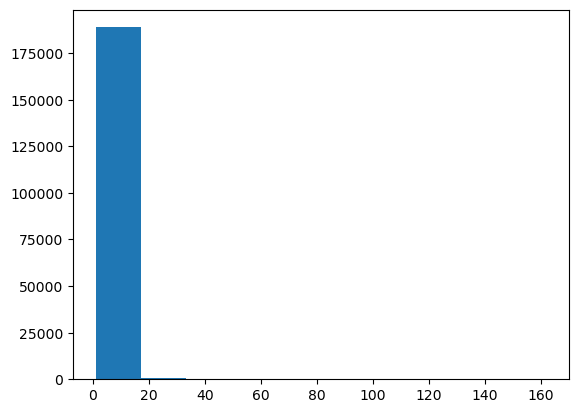

In [48]:
plt.hist(df['items_in_order'], bins=10) 
plt.show()

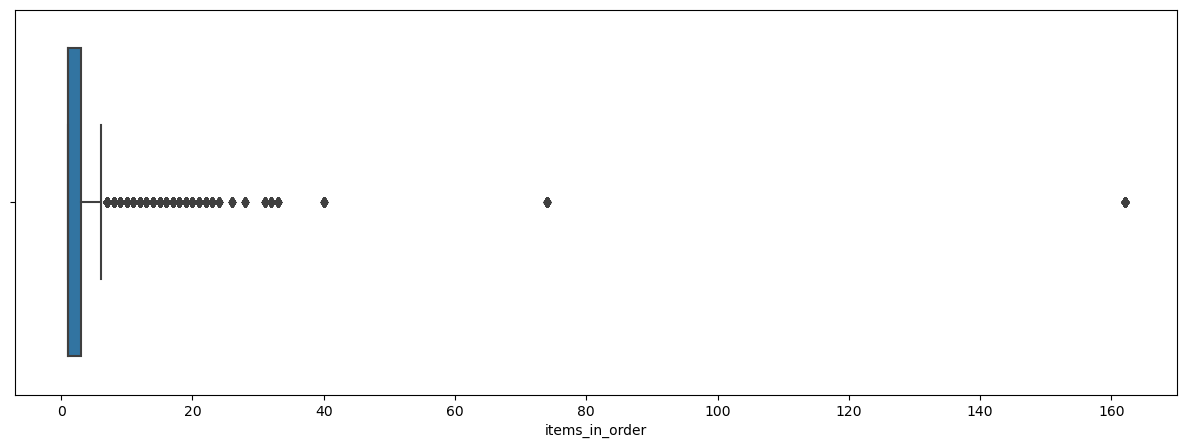

In [51]:
# Установка размера графика
plt.figure(figsize=(15, 5))  # Здесь (10, 6) - это размеры графика в дюймах (ширина, высота)

# Построение горизонтального боксплота для столбца 'имя_столбца' с использованием seaborn
sns.boxplot(data=df, x='items_in_order', orient='h')
plt.show()

Можно сказать, что больше 10 товаров в заказе встречается крайне редко. Для дальнейшего решения задачи можно отсееть все заказы, в которых больше 10 товаров. Максимальное число товаров в заказе - 160 - это скорее аномалия.

In [52]:
carton_new = carton.copy()

In [53]:
carton_new['carton_volume'] = carton_new['LENGTH']*carton_new['WIDTH']*carton_new['HEIGHT']

In [54]:
# Группировка по 'orderkey' и 'transportation rules' и вычисление суммы 'pack_volume'
df['total_pack_volume'] = df.groupby(['orderkey', 'transportation rules'])['pack_volume'].transform('sum')


In [55]:
# Вычисление суммы 'pack_volume' с учетом фильтрации по 'description'
df['total_pack_volume_filtered'] = df.loc[df['description'] != 'не требует упаковки'].groupby(['orderkey', 'transportation rules']) \
    ['pack_volume'].transform('sum')

In [56]:
# добавляем название упаковки
def add_packaging(row):
    product_volume = row['total_pack_volume_filtered']
    matching_cartons = carton_new[carton_new['carton_volume'] >= product_volume]
    if not matching_cartons.empty:
        packaging_volume = matching_cartons['carton_volume'].min()
        packaging_name = carton_new.loc[carton_new['carton_volume'] == packaging_volume, 'selected_carton'].values[0]
    else:
        packaging_name = 'NONPACK'
    return packaging_name

df['packaging'] = df.apply(add_packaging, axis=1)


In [57]:
df

,orderkey,box_num,selected_carton,sel_calc_cube,recommended_carton,pack_volume,rec_calc_cube,goods_wght,sku,a,b,c,cargotype,description,total_category,transportation rules,items_in_order,total_pack_volume,total_pack_volume_filtered,packaging
0,d48f3211c1ffccdc374f23139a9ab668,1,NONPACK,0,YML,2046,108000,0.100,af49bf330e2cf16e44f0be1bdfe337bd,11.0,6.0,31.0,970,впитывает запах,"одежда, обувь, аксессуары",не требует особых правил перевозки,3,6138,6138.0,MYC
51,4b33fcc98ea1f59d6fe4eb2e0a48bb4b,1,STRETCH,0,MYD,3050,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,200,техника и электроника,электроника,не требует особых правил перевозки,1,3050,3050.0,MYB
52,01277a58f3aa98c06db9046699ec162d,1,MYE,26277,MYD,3050,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,200,техника и электроника,электроника,не требует особых правил перевозки,1,3050,3050.0,MYB
53,19ca05955536663c48d156fdb245576f,1,STRETCH,0,MYD,3050,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,200,техника и электроника,электроника,не требует особых правил перевозки,1,3050,3050.0,MYB
54,e14e21fd406ff6774e69660a492a932a,1,MYE,26277,MYD,3050,15579,0.896,6287a74b664fd8ad4ed5c541b399a82b,18.6,3.3,49.7,200,техника и электроника,электроника,не требует особых правил перевозки,1,3050,3050.0,MYB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856882,49a255ef0fa15f30c54251d9e386e480,3,NONPACK,0,NONPACK,1617,0,0.430,29dbb42befa2f176eb50828deba50afc,77.0,3.0,6.0,200,техника и электроника,электроника,не требует особых правил перевозки,1,1617,1617.0,YMU
856892,379f923b506613b3bd8d3f1bf1cc7092,2,YMW,21812,YMW,6000,21812,0.150,b7ab1a9260ebc1d53774714b24c02dd3,15.0,20.0,20.0,200,техника и электроника,электроника,не требует особых правил перевозки,4,14578,6800.0,MYC
856895,2da5e30c36487a43f6b647f1fa223da4,1,MYE,10836,MYE,1400,10836,0.160,ba0b176dc645058663de285b479163b3,50.0,1.0,28.0,340,не требует упаковки,прочее,не требует особых правил перевозки,3,5237,NaN,NONPACK
856896,27ac554d4db530391356b9e3125c5f6d,1,MYC,4560,YMC,2688,8525,0.140,0940ce4ed3c65c5713a169bdf824dfcc,28.0,8.0,12.0,340,не требует упаковки,прочее,не требует особых правил перевозки,1,2688,NaN,NONPACK


In [58]:
df['packaging'].nunique()

26

In [59]:
corr_matrix = df.corr()

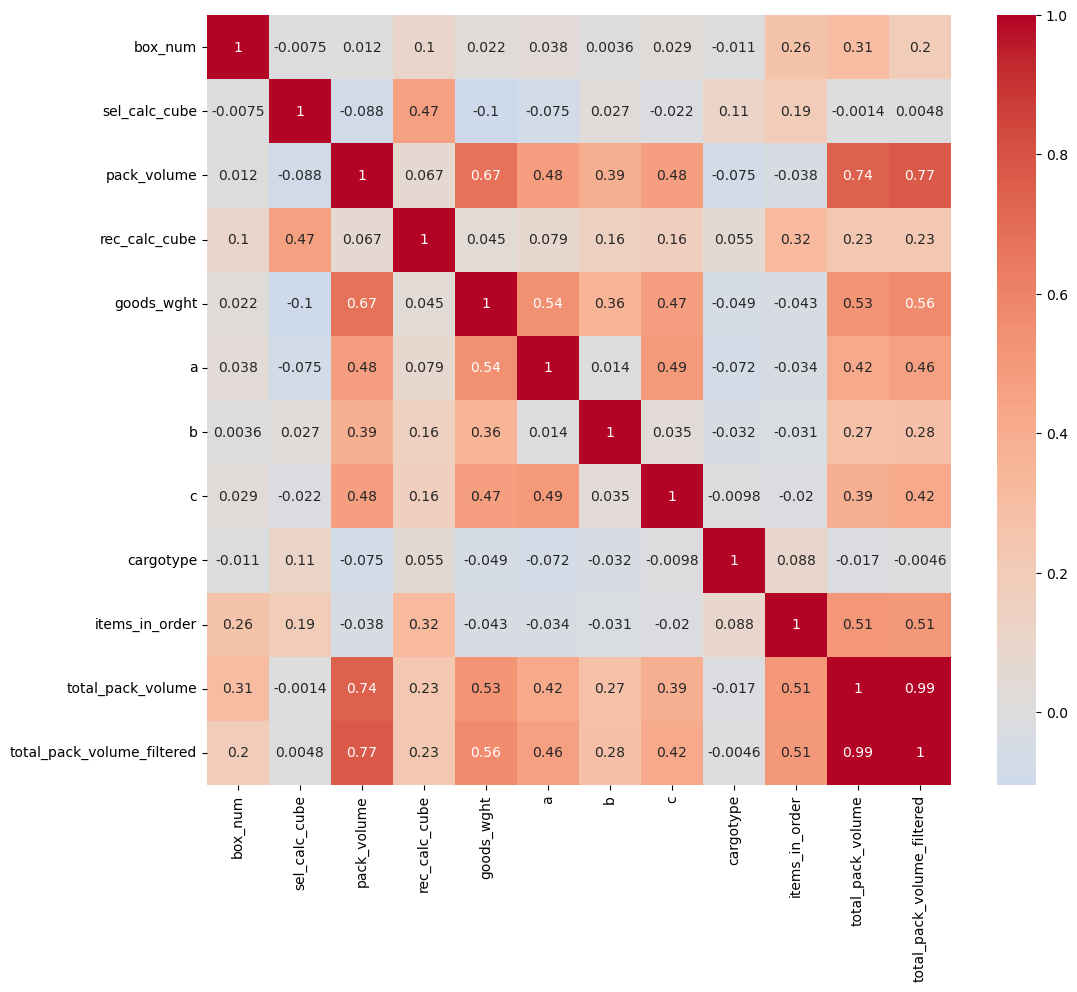

In [60]:
# Создание тепловой карты
plt.figure(figsize=(12, 10)) 
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

В данных присутствует мультиколленеарность признаков, это общий объем упаковки и отфильтрованный объем для упаковки. По факту это один и тот же признак, только отфильтрованный объем упаковки учитывает, что есть товар, для которого упаковка не требуется. Удалим лишний признак. Так же удалим еще номер коробки, сведения об id, общий объекм товаров в заказе.

In [61]:
df_new = df.drop(['box_num', 'sel_calc_cube', 'rec_calc_cube', 'orderkey', 'selected_carton', 'recommended_carton',
                  'sku', 'cargotype', 'total_category', 'total_pack_volume'], axis=1)

In [62]:
df_new

,pack_volume,goods_wght,a,b,c,description,transportation rules,items_in_order,total_pack_volume_filtered,packaging
0,2046,0.100,11.0,6.0,31.0,впитывает запах,не требует особых правил перевозки,3,6138.0,MYC
51,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,1,3050.0,MYB
52,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,1,3050.0,MYB
53,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,1,3050.0,MYB
54,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,1,3050.0,MYB
...,...,...,...,...,...,...,...,...,...,...
856882,1617,0.430,77.0,3.0,6.0,техника и электроника,не требует особых правил перевозки,1,1617.0,YMU
856892,6000,0.150,15.0,20.0,20.0,техника и электроника,не требует особых правил перевозки,4,6800.0,MYC
856895,1400,0.160,50.0,1.0,28.0,не требует упаковки,не требует особых правил перевозки,3,NaN,NONPACK
856896,2688,0.140,28.0,8.0,12.0,не требует упаковки,не требует особых правил перевозки,1,NaN,NONPACK


Добавим еще немного информации об упаковке. У нас есть названия коробок, определим их размеры и общий объем, возможно это будет полезно.

In [63]:
carton_new.rename(columns={'selected_carton': 'packaging'}, inplace=True)

In [64]:
df_new = df_new.merge(carton_new, how='left', on='packaging')

In [65]:
df_new=df_new[df_new['items_in_order']<=10]

In [66]:
df_new

,pack_volume,goods_wght,a,b,c,description,transportation rules,items_in_order,total_pack_volume_filtered,packaging,LENGTH,WIDTH,HEIGHT,carton_volume
0,2046,0.100,11.0,6.0,31.0,впитывает запах,не требует особых правил перевозки,3,6138.0,MYC,30.0,38.0,7.4,8436.0
1,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,1,3050.0,MYB,22.0,32.0,4.9,3449.6
2,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,1,3050.0,MYB,22.0,32.0,4.9,3449.6
3,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,1,3050.0,MYB,22.0,32.0,4.9,3449.6
4,3050,0.896,18.6,3.3,49.7,техника и электроника,не требует особых правил перевозки,1,3050.0,MYB,22.0,32.0,4.9,3449.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189723,1617,0.430,77.0,3.0,6.0,техника и электроника,не требует особых правил перевозки,1,1617.0,YMU,27.0,24.0,4.0,2592.0
189724,6000,0.150,15.0,20.0,20.0,техника и электроника,не требует особых правил перевозки,4,6800.0,MYC,30.0,38.0,7.4,8436.0
189725,1400,0.160,50.0,1.0,28.0,не требует упаковки,не требует особых правил перевозки,3,NaN,NONPACK,0.0,0.0,0.0,0.0
189726,2688,0.140,28.0,8.0,12.0,не требует упаковки,не требует особых правил перевозки,1,NaN,NONPACK,0.0,0.0,0.0,0.0


# Обучение

In [73]:
# Разделение на признаки (X) и целевой признак (y)
X = df_new.drop('packaging', axis=1)
y = df_new['packaging']

In [74]:
# Разделение на обучающий и тестовый наборы данных
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

In [75]:
X_train.shape

(130083, 13)

In [76]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130083 entries, 64348 to 172837
Data columns (total 13 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   pack_volume                 130083 non-null  int64  
 1   goods_wght                  130083 non-null  float64
 2   a                           130083 non-null  float64
 3   b                           130083 non-null  float64
 4   c                           130083 non-null  float64
 5   description                 130083 non-null  object 
 6   transportation rules        130083 non-null  object 
 7   items_in_order              130083 non-null  int64  
 8   total_pack_volume_filtered  116333 non-null  float64
 9   LENGTH                      130083 non-null  float64
 10  WIDTH                       130083 non-null  float64
 11  HEIGHT                      130083 non-null  float64
 12  carton_volume               130083 non-null  float64
dtypes: float64

## Модель

In [77]:
cat_features = [5, 6]

In [78]:
# Создание экземпляра LabelEncoder
label_encoder = LabelEncoder()

# Применение Label Encoding к целевой переменной y_train
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [79]:
base_model = CatBoostClassifier(
    iterations= 1000, # сколько деревьев в ансамбле
    #learning_rate=0.5, #регурялизация бустинга
    early_stopping_rounds=20, #ограничение на обучение (в данном случае если 20 эпох подряд качество ухудшается модель перестает обучаться)
    loss_function='MultiClass',
    random_seed=42,
    train_dir='base_model',
    verbose=0 #если вербосс = 0, модель не будет выводить на экран процесс обучения
)

In [80]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_encoded, test_size=0.40, random_state=42)

In [81]:
base_model.fit(
    X_train, y_train,
    cat_features=cat_features, eval_set = (X_val, y_val))

In [83]:
y_pred_proba = base_model.predict_proba(X_test)

In [95]:
# Раскодирование предсказанных вероятностей
y_pred = label_encoder.inverse_transform(np.argmax(y_pred_proba, axis=1))

Метрики, которые будем использовать для оценки качества:

F1-мера - является гармоническим средним между precision и recall. 

ROC AUC - измеряет способность модели разделять классы, усредняя площадь под кривой полученной из ROC-кривой. Он особенно полезен, когда важно оценить общую способность модели различать классы, независимо от выбора порога для принятия решения.

In [96]:
# Преобразование вероятностей в метки классов
y_pred_labels = np.argmax(y_pred_proba, axis=1)

# Расчет F1-меры для мультиклассовой классификации
f1_score = f1_score(y_test_encoded, y_pred_labels, average='macro')
print("F1-мера:", f1_score)

F1-мера: 1.0


Если F1-мера равна 1.0, это означает, что модель идеально предсказывает метки классов для данного набора данных и достигает идеального баланса между точностью и полнотой. 

Возможно, что данные в выборке слишком просты, или модель переобучена.

In [93]:
roc_auc = roc_auc_score(y_test_encoded, y_pred_proba, multi_class='ovr')  # используйте multi_class='ovr' для ROC AUC в мультиклассовой классификации

In [94]:
roc_auc

1.0

Значение ROC AUC 1.0 указывает на то, что модель идеально разделяет положительные и отрицательные классы для всех объектов.

Если обе метрики равны 1.0, это явно указывает на переобучение модели.

Рекомендуется провести проверку на других наборах данных для получения более полной картины о производительности модели.

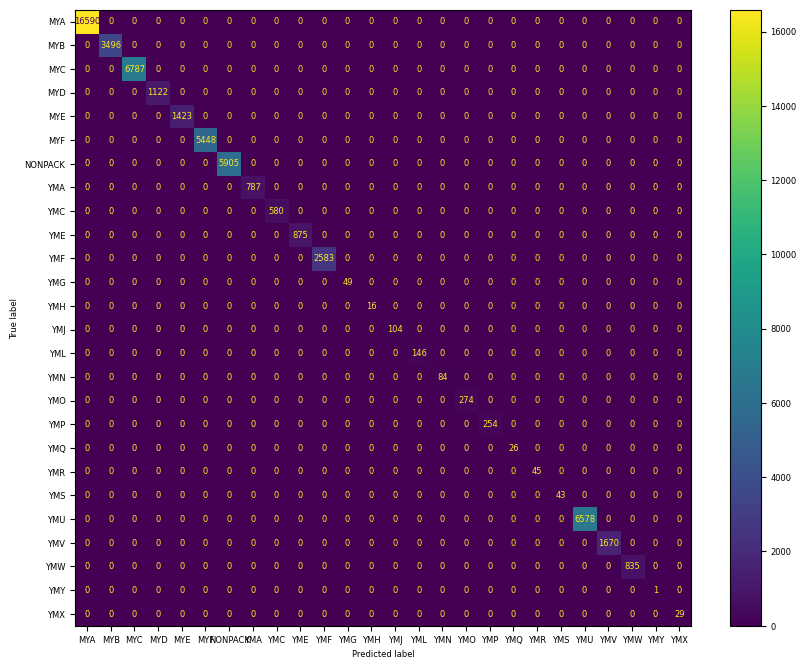

In [112]:
# Создание матрицы ошибок
cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

# Установка размера графика
plt.rc('figure', figsize=(10, 8))


In [114]:
# Сохранение модели в файл
with open("file.pcl", "wb") as fid:
    pickle.dump(base_model, fid)

Вывод:

Была использована базовая модель CatBoost, задача мультиклассификации решена, но к сожалению модель переобучена, и показывает идеальные результаты на этапе ее оценки. Из матрицы ошибок мы видим, что все классы она предсказала верно, возможно это указывает на то, что данные для модели слишком простые.